In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

In [68]:
from sklearn.metrics import mean_squared_error

In [69]:
df_sub=pd.read_csv("datasets/sample_submission.csv")
df_train=pd.read_csv("datasets/train.csv")
df_test=pd.read_csv("datasets/test.csv")

In [70]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [71]:
import seaborn as sns

In [72]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

#잘모르겠음.. 왜?

Columns in df_train with more than 10% missing values:
fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64

Columns in df_test with more than 10% missing values:
fuel_type       2.691543
accident        1.298433
clean_title    11.328666
dtype: float64


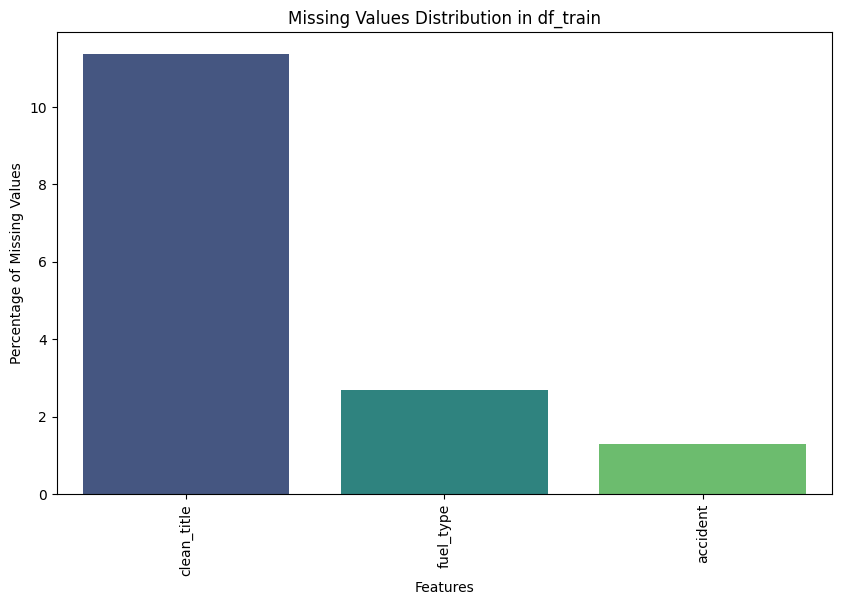

In [73]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

In [75]:
print(type(df_train))
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
           brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                    

In [76]:
from dython.nominal import associations

associations_df = associations(df_train, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']

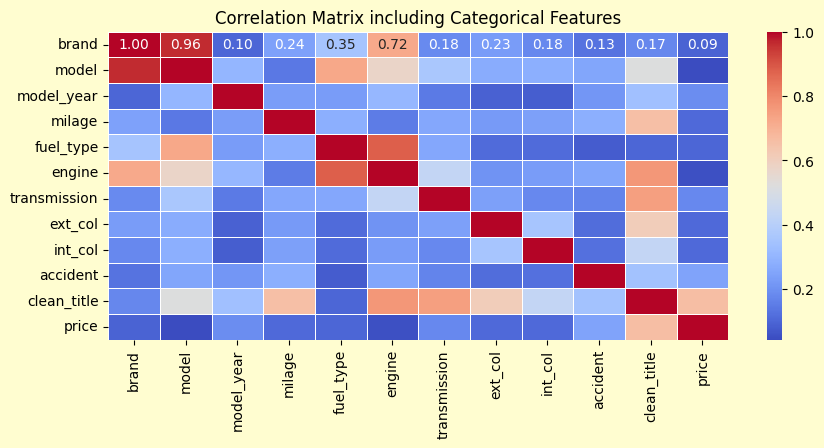

In [77]:
plt.figure(figsize=(10, 4))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [78]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [79]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [80]:
df_train_imputed = knn_impute(df_train, n_neighbors=25)
df_test_imputed = knn_impute(df_test, n_neighbors=25)

In [81]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [82]:
df_train_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [83]:
df_test_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26.0,1390.0,2015.0,98000.0,2.0,325.0,16.0,304.0,10.0,1.0,0.0
1,26.0,1377.0,2020.0,9142.0,3.0,787.0,31.0,263.0,14.0,1.0,0.0
2,14.0,636.0,2022.0,28121.0,2.0,540.0,3.0,304.0,57.0,1.0,1.0
3,3.0,182.0,2016.0,61258.0,2.0,192.0,39.0,261.0,14.0,1.0,1.0
4,3.0,181.0,2018.0,59000.0,2.0,364.0,38.0,128.0,14.0,1.0,0.0


In [84]:
df_train = df_train_imputed
df_test = df_test_imputed

In [85]:
df_train.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [86]:
current_year = 2024
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Tesla']


def create_features(df):
    #df['vehicle_age'] = current_year - df['model_year']  
    #df['vehicle_age_int'] = df['vehicle_age'].astype(int)
    #df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    #df['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)   
    df['rare_fuel_type'] = df['fuel_type'].apply(lambda x: 0 if x in ['Petrol', 'Diesel'] else 1)
    df['is_automatic'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
    df['has_accident_history'] = df['accident'].apply(lambda x: 1 if x != 'Unknown' and x != 'None' else 0)
    #df['engine_power_category'] = pd.qcut(df['engine'], q=3, labels=['Low', 'Medium', 'High'])
    df['color_match'] = df.apply(lambda row: 1 if row['ext_col'] == row['int_col'] else 0, axis=1)
    df['is_luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    return df
#df_train = create_features(df_train)
#df_test = create_features(df_test)

In [87]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [88]:
df_test.shape,df_train.shape

((125690, 11), (188533, 12))

In [89]:
def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(df_train, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

In [90]:
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,49.0,304.0,10.0,1.0,0.0,27500.0
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,31.0,304.0,14.0,0.0,0.0,30000.0
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,23.0,304.0,14.0,1.0,0.0,86900.0
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,82.0,14.0,1.0,1.0,84900.0


In [91]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,38.0,304.0,155.0,1.0,0.0,29950.0


In [92]:
df_train_no_outliers.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

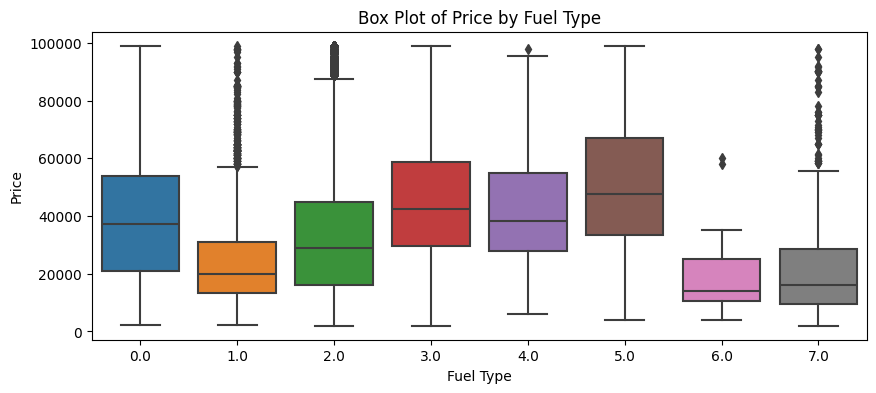

In [95]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='fuel_type', y='price', data=df_train_no_outliers)
plt.title('Box Plot of Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

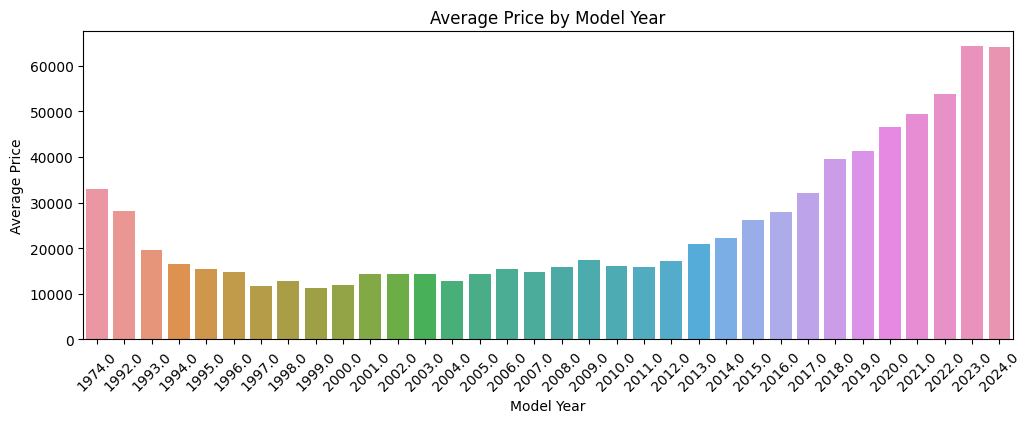

In [96]:
plt.figure(figsize=(12, 4))
sns.barplot(x='model_year', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

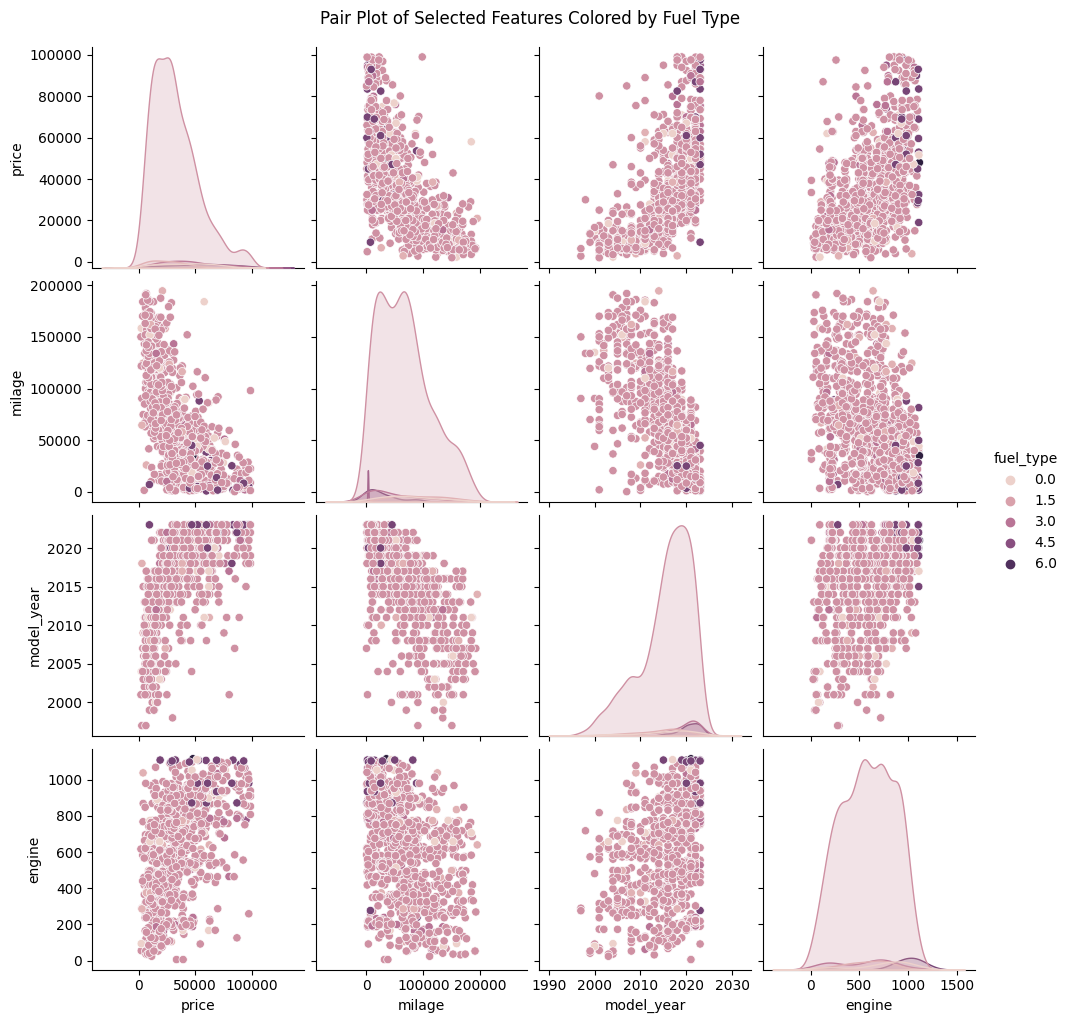

In [97]:
x = df_train_no_outliers[:1000]
sns.pairplot(x[['price', 'milage', 'model_year', 'engine', 'fuel_type']], hue='fuel_type')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

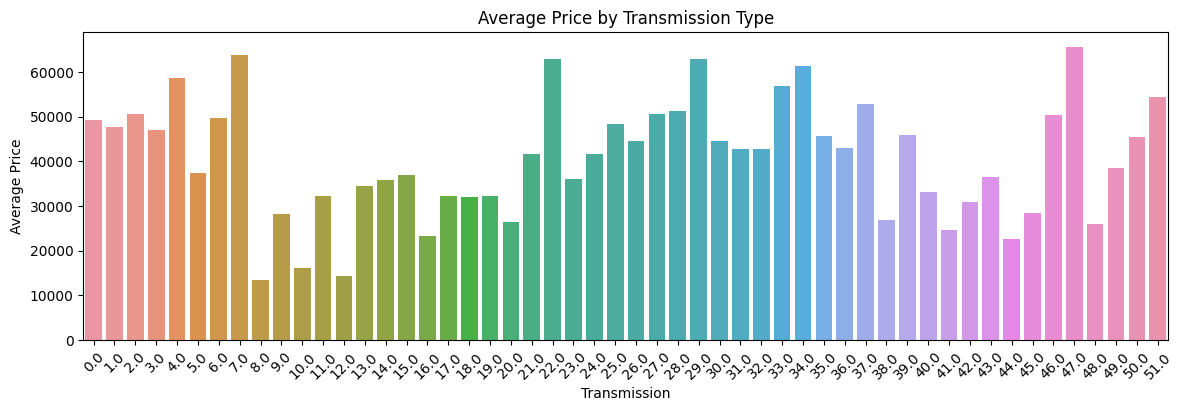

In [98]:
plt.figure(figsize=(14, 4))
sns.barplot(x='transmission', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [99]:
y = df_train['price'] 
X = df_train.drop(['price'],axis=1)

Model Training

In [100]:
df_train.shape

(188533, 12)

In [101]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [102]:
df_test.shape

(125690, 11)

In [103]:
df_test.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

In [104]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X)
scaled_test_data = scaler.transform(df_test)

In [106]:
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_params={
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1,
                 'early_stopping_rounds': 200,
}


lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))


for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   #early_stopping_rounds=10,
                   #verbose=False                
                  )

    
    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits 
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/3...
Fold 1 RMSE: 66541.0123
Training fold 2/3...
Fold 2 RMSE: 75216.5742
Training fold 3/3...
Fold 3 RMSE: 76078.5452
Overall RMSE (LGBMRegressor): 72739.6514


In [108]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
from xgboost import XGBRegressor

xgb_params = {
    'lambda': 0.03880258557285165,
    'alpha': 0.02129832295514386,
    'colsample_bytree': 0.4,
    'subsample': 0.7,
    'learning_rate': 0.014,
    'max_depth': 17,
    'random_state': 2020,
    'min_child_weight': 85,
    'n_estimators': 10000,
}

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric="rmse",
                  early_stopping_rounds=200,
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits  

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")


Training fold 1/3...


TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
xgb_test_predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
lgbm_test_predictions

array([18591.04915907, 80884.58634621, 65036.18970509, ...,
       22360.30205911, 15742.10280238, 35381.67999001])

In [ ]:
df_sub['price']= lgbm_test_predictions*0.66+xgb_test_predictions*0.34

In [ ]:
df_sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,price
0,188533,12270.092445
1,188534,53383.826989
2,188535,42923.885205
3,188536,15587.773481
4,188537,19512.210275
...,...,...
125685,314218,17943.442541
125686,314219,31158.959926
125687,314220,14757.799359
125688,314221,10389.787850


<Axes: >

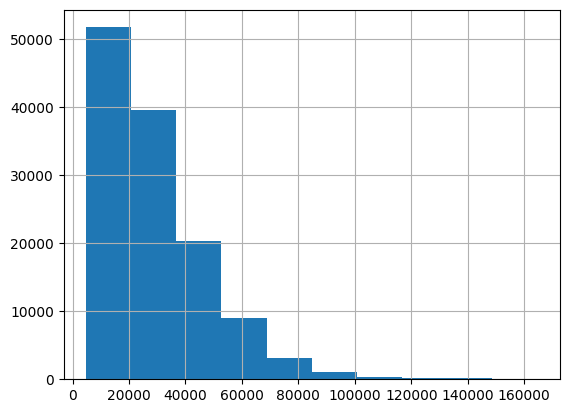

In [ ]:
df_sub['price'].hist()